# **Assignment 3: Milestone I | Natural Language Processing**
## **Task 2 & 3. Generating Feature Representations & Classifying Clothing Reviews**

**Group 01:**
- Tran Tu Tam (s3999159)
- Phan Nhat Minh (s3978598)
- Le Thien Son (s3977955)

**Environment**: 

To ensure full reproducibility, the Python environment used in this assignment is managed with **conda**. We worked with **Python 3.10** on **conda 25.7.0** inside Jupyter Notebook.  

The exact environment can be recreated by running the following command with the provided `environment.yaml` file:

```bash
conda env create -f environment.yaml
```

After creating the environment, activate it with:

```bash
conda activate ap4ds-a3
```

**Libraries used**: 
* re, collections.Counter
* numpy, pandas, scipy
* matplotlib, seaborn
* gensim (KeyedVectors, downloader API)
* scikit-learn (model_selection, pipeline, preprocessing, feature_extraction, metrics, classifiers)
* imbalanced-learn (SMOTE, Pipeline)

## Introduction

In this notebook, we continue from the preprocessing work in **Task 1** and focus on two main goals:  

- **Task 2: Generating Feature Representations**  
  We transform the cleaned clothing reviews into numerical formats suitable for machine learning.  
  Three types of representations are built:  
  - **Bag-of-Words (BoW)** using the fixed vocabulary from Task 1  
  - **Unweighted embeddings** (FastText average vectors)  
  - **TF-IDF weighted embeddings** (FastText weighted by IDF scores)  
  Along the way, we check coverage of the embedding model, inspect out-of-vocabulary cases, and save the representations for downstream tasks.  

- **Task 3: Clothing Review Classification**  
  Using the generated features, we train and evaluate multiple classifiers to predict whether a clothing item is **recommended** or not (`Recommended IND`).  
  - **Question 1:** Which representation (BoW vs embeddings) works best?  
  - **Question 2:** Does adding the **Title** of reviews improve performance compared to Text alone?  

For both questions, we use **cross-validation** with multiple metrics (Accuracy, F1, ROC-AUC, Balanced Accuracy) to account for class imbalance.  
We also experiment with **SMOTE oversampling** vs **class weighting** to handle imbalance in the target labels.  

## Importing Libraries 

In [344]:
# Standard Library
import re
from collections import Counter

# Third-Party Libraries
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Embeddings
from gensim.models import KeyedVectors
import gensim.downloader as api

# Machine Learning (Scikit-learn)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore only ConvergenceWarning from sklearn
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# (optional) also suppress generic UserWarning if needed
warnings.filterwarnings("ignore", category=UserWarning)

## Task 2. Generating Feature Representations for Clothing Reviews

With preprocessing done in Task 1, the next step is to turn the cleaned reviews into numerical features.  
These representations let us feed the text into machine learning models later in Task 3.

### 2.1 Load Processed Data

To begin, we load the cleaned dataset from Task 1 (`processed.csv`).  
This file includes the tokenized and filtered reviews, and for this step we focus on the `Review Text` column.  

We then convert these reviews into a list of strings so they can be used directly when creating the different feature representations in Task 2.

In [345]:
# Load the processed dataset from Task 1
df = pd.read_csv("../output/processed.csv")

# Keep only non-empty processed token lists
df = df[df["tokens_typo_fixed"].str.strip().astype(bool)]

# Convert the cleaned tokens back into review strings (space-joined)
reviews = df["tokens_typo_fixed"].astype(str).tolist()

print("Head of processed reviews:")
print(reviews[:5])

Head of processed reviews:
["['high', 'hope', 'wanted', 'work', 'initially', 'petite', 'usual', 'found', 'outrageously', 'fact', 'zip', 'reordered', 'petite', 'medium', 'half', 'nicely', 'bottom', 'half', 'tight', 'layer', 'cheap', 'net', 'layer', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directly', 'zipper']", "['jumpsuit', 'fun', 'flirty', 'fabulous', 'time', 'compliment']", "['shirt', 'due', 'adjustable', 'front', 'tie', 'length', 'legging', 'sleeveless', 'pair', 'cardigan', 'shirt']", "['tracy', 'reese', 'dress', 'petite', 'foot', 'tall', 'brand', 'pretty', 'package', 'lot', 'skirt', 'long', 'full', 'overwhelmed', 'frame', 'stranger', 'alteration', 'shortening', 'skirt', 'embellishment', 'garment', 'idea', 'style', 'work', 'returned']", "['basket', 'hte', 'person', 'store', 'pick', 'teh', 'pale', 'hte', 'gorgeous', 'turn', 'perfectly', 'baggy', 'hte', 'x', 'hte', 'bummer', 'petite', 'decided', 'jeans', 'pant', 'skirt', 'oops']"]


In [346]:
df.shape

(19652, 14)

Next, we load the vocabulary file created in Task 1.  

The file `vocab.txt` contains all valid tokens from the processed reviews, each mapped to a unique integer index. This mapping is important because it keeps our feature representations in Task 2 aligned to a **consistent and reproducible index space**.  

We read the file line by line, split each entry into the token and its index, and store them in a Python dictionary called `vocab`. This dictionary will be our reference point for building bag-of-words vectors and other feature encodings.

In [347]:
with open("../output/vocab.txt", "r") as f:
    vocab_lines = f.readlines()

vocab = {line.split(":")[0]: int(line.strip().split(":")[1]) for line in vocab_lines}

print("\nHead of vocab:")
for i, (word, idx) in enumerate(vocab.items()):
    if i >= 5:
        break
    print(f"{word}: {idx}")


Head of vocab:
a-cup: 0
a-flutter: 1
a-frame: 2
a-kind: 3
a-line: 4


### 2.2 Bag-of-Words Model: Count Vector Representation

We start by generating the **bag-of-words (BoW) representation** for each review. This approach converts each review into a sparse vector where:  
- The **index** corresponds to a token from the vocabulary created in Task 1.  
- The **value** shows how many times that token appears in the review.  

In [348]:
# Build CountVectorizer using fixed vocab
vectorizer = CountVectorizer(vocabulary=vocab)
X_counts = vectorizer.fit_transform(reviews)

### 2.3 Load FastText Word Vectors

For the embedding model, we use **FastText** from `gensim`’s API (`fasttext-wiki-news-subwords-300`).  
This pre-trained model maps each word into a 300-dimensional vector and can handle **out-of-vocabulary (OOV)** words by using subword information. That makes it especially useful for messy, user-generated reviews where typos and rare words are common.  

Once loaded, we confirm the embedding dimension and use these vectors to build:  
- **Unweighted document vectors** (average of word embeddings).  
- **Weighted document vectors** (TF-IDF weighted average).  

These representations will feed into our classification models in Task 3.

In [349]:
# Download FastText model from gensim
print("Loading FastText model from gensim... (This may take a few minutes on the first run)")
ft_model = api.load('fasttext-wiki-news-subwords-300')

embedding_dim = ft_model.vector_size

# Check if the model is loaded correctly
print("Embedding dimension:", embedding_dim)

Loading FastText model from gensim... (This may take a few minutes on the first run)
Embedding dimension: 300


### 2.4 Tokenization Consistency

To make sure our feature extraction is accurate, we re-tokenize the reviews into word lists before applying Bag-of-Words or embedding methods.  
We use the **same regex pattern** from Task 1 so that the tokens stay consistent with the vocabulary and preprocessing already applied.  
This step ensures that every feature representation aligns with the cleaned dataset.  

In [350]:
tokenizer = re.compile(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?") 

def tokenize(text): 
    tokens = tokenizer.findall(text.lower()) 
    clean_tokens = [t.strip("-'") for t in tokens] # remove trailing punctuation if needed 
    return clean_tokens 

tokenized_reviews = [tokenize(r) for r in reviews] 

### 2.5 OOV Diagnostics

We checked how well the FastText model covers our dataset vocabulary by calculating the out-of-vocabulary (OOV) rate.  

In [351]:
def compute_coverage(token_lists, model):
    total = sum(len(toks) for toks in token_lists)
    known = sum(sum(1 for tok in toks if tok in model) for toks in token_lists)
    return {
        "total_tokens": total,
        "covered_tokens": known,
        "coverage_pct": round(100 * known / total, 2)
    }

coverage = compute_coverage(tokenized_reviews, ft_model)
print("FastText OOV Coverage:", coverage)

FastText OOV Coverage: {'total_tokens': 355512, 'covered_tokens': 353286, 'coverage_pct': 99.37}


The model covers **99.37%** of all tokens, leaving only **0.63%** unmatched.  
This high coverage suggests FastText handles our reviews very well. Still, we take a closer look at the OOV cases to confirm they won’t affect downstream results in a meaningful way.

In [352]:
missing = Counter( 
    tok 
    for review in tokenized_reviews 
    for tok in review 
    if tok not in ft_model 
) 

print("Top OOV tokens:", missing.most_common(10))
print("All missing tokens:")
for token, count in missing.items():
    print(f"{token}: {count}")

Top OOV tokens: [('pilcro', 274), ('maeve', 156), ('xsp', 92), ("would've", 83), ('xxsp', 77), ("retailer's", 56), ('xsmall', 48), ("could've", 38), ("model's", 35), ('cartonnier', 23)]
All missing tokens:
linen-like: 5
year's: 15
xsp: 92
would've: 83
bralette: 21
could've: 38
antro: 12
should've: 19
square-apple: 2
jammie: 2
sweater-like: 6
cami's: 3
swtr: 5
maeve: 156
that'll: 2
xxsp: 77
ranna: 3
pants-they: 2
pilcro: 274
xsmall: 48
woman's: 9
small-chested: 10
xs-s: 13
retailer's: 56
antho: 12
v-cut: 4
work-appropriate: 7
maternity-ish: 8
maternity-esque: 2
friend's: 8
season's: 4
as-pictured: 3
xspetite: 16
peek-a: 7
marled: 12
flatering: 8
today's: 3
flirtiness: 2
fit-and: 7
c-cup: 2
valentine's: 5
cartonnier: 23
one's: 20
racerback: 9
true-to: 21
m-l: 5
mid-shin: 2
model's: 35
throw-on: 6
and-go: 3
husband's: 11
mockneck: 4
lbd: 13
flowiness: 6
amalfi: 3
skinny's: 3
under-layer: 6
orange-y: 2
purchas: 5
moulinette: 9
sweatercoat: 7
she's: 23
d-dd: 7
comf: 5
pointelle: 9
mid-hip: 

Upon reviewing the missing tokens, we found that most are either **misspellings/variants** (e.g., `swtr`, `flowey`) or **tokens with apostrophes** (e.g., `"would've"`, `"model's"`), which FastText doesn’t always match directly.  

Since the OOV rate is very low and the unmatched tokens are not critical, we decided not to apply extra corrections or manual filtering. The model already provides strong coverage, making it reliable enough for embedding generation as is.

### 2.6 Generate Unweighted FastText Embedding

Our first embedding-based representation is the **unweighted average of word vectors**.  
In this approach, each review is turned into a single vector by averaging the embeddings of its tokens:  

- For each token, we check if it exists in the FastText model.  
- If it does, we collect its 300-dimensional vector.  
- We then take the simple average of all vectors in that review.  
- If a review has no known tokens, we assign a zero vector of the same dimension.  

In [353]:
def avg_embedding(tokens, model):
    vectors = [model[w] for w in tokens if w in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

unweighted_embeds = np.array([avg_embedding(tokens, ft_model) for tokens in tokenized_reviews])

This gives us one fixed-size vector per review, offering a simple way to capture the overall semantic meaning of the text without applying any weighting.  

To verify the output, we preview the first few embedding values from a sample review using FastText.  

In [354]:
def validator_token_embeddings(tokens, ft_model, dims=5, limit=5):
    print(f"FastText token-wise vectors (first {dims} dims, showing up to {limit} tokens):\n")
    shown = 0
    for token in tokens:
        if token in ft_model:
            vec = ft_model[token][:dims]
            rounded = [f"{v:.4f}" for v in vec]
            print(f"{token}: [{', '.join(rounded)}]")
            shown += 1
        else:
            print(f"{token}: [OOV]")
            shown += 1
        if shown >= limit:
            break

test_idx = 42
validator_token_embeddings(tokenized_reviews[test_idx], ft_model, dims=8, limit=5)


FastText token-wise vectors (first 8 dims, showing up to 5 tokens):

armhole: [-0.0017, -0.0550, -0.0264, -0.0018, -0.0155, -0.0128, 0.0309, -0.0929]
bit: [-0.0609, -0.0703, -0.0337, 0.1412, -0.0352, 0.0791, 0.0059, -0.1402]
oversized: [-0.0013, 0.0522, -0.0133, -0.0303, 0.0218, -0.0285, -0.0024, -0.0897]
older: [-0.0147, 0.0463, -0.0061, 0.0066, -0.0126, 0.0617, -0.0522, -0.0952]
woman: [-0.0890, 0.0070, 0.0440, 0.0096, -0.0066, 0.0220, 0.0380, -0.1163]


Below is a sample output from review index 42, showing the first 8 dimensions of 5 token vectors.  
All selected tokens are successfully recognized and mapped to meaningful embeddings.  

This confirms that the embeddings are being computed as expected. With this validation, we can now move on to the next step.  

### 2.7 Generate TF-IDF Weighted FastText Embedding

We now improve on the simple averaging method by applying **TF-IDF weighting** to the word embeddings.  
This gives more importance to informative words while downplaying very common ones.  

Concept Overview:  
- Compute TF-IDF values for all tokens using the vocabulary from Task 1.  
- For each review, retrieve FastText embeddings for tokens that exist in both the model and TF-IDF dictionary.  
- Scale each word vector by its TF-IDF weight.  
- Take the weighted average of these vectors to form the final review embedding.  
- If a review has no matching tokens, assign a zero vector of the same dimension.

In [355]:
# Use same vocab as before
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
X_tfidf = tfidf_vectorizer.fit_transform(reviews)
idf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

def tfidf_weighted_embedding(tokens, model, idf_dict):
    vectors = []
    weights = []
    for token in tokens:
        if token in model and token in idf_dict:
            vectors.append(model[token] * idf_dict[token])
            weights.append(idf_dict[token])
    if not vectors:
        return np.zeros(model.vector_size)
    return np.sum(vectors, axis=0) / np.sum(weights)

weighted_embeds = np.array([
    tfidf_weighted_embedding(tokens, ft_model, idf_weights)
    for tokens in tokenized_reviews
])

This weighted representation captures both the semantic meaning of words and their relative importance across the reviews, making it a stronger candidate for classification.  

To validate the output, we preview a few token embeddings alongside their corresponding TF-IDF weights.

In [356]:
def validator_weighted_tokens(tokens, model, idf_dict, dims=5, limit=5):
    print(f"TF-IDF Weighted token-wise vectors (first {dims} dims, up to {limit} tokens):\n")
    shown = 0
    for token in tokens:
        if token in model and token in idf_dict:
            vec = model[token] * idf_dict[token]
            rounded = [f"{v:.4f}" for v in vec[:dims]]
            print(f"{token}: [{', '.join(rounded)}]  (weight: {idf_dict[token]:.4f})")
            shown += 1
        elif token in model:
            print(f"{token}: [valid token, missing IDF]")
            shown += 1
        else:
            print(f"{token}: [OOV]")
            shown += 1
        if shown >= limit:
            break

test_idx = 42
validator_weighted_tokens(tokenized_reviews[test_idx], ft_model, idf_weights, dims=8, limit=5)

TF-IDF Weighted token-wise vectors (first 8 dims, up to 5 tokens):

armhole: [-0.0096, -0.3115, -0.1492, -0.0103, -0.0876, -0.0726, 0.1749, -0.5260]  (weight: 5.6602)
bit: [-0.1914, -0.2207, -0.1059, 0.4434, -0.1105, 0.2485, 0.0187, -0.4404]  (weight: 3.1410)
oversized: [-0.0072, 0.2858, -0.0728, -0.1658, 0.1196, -0.1559, -0.0131, -0.4908]  (weight: 5.4743)
older: [-0.1107, 0.3498, -0.0460, 0.0501, -0.0951, 0.4661, -0.3941, -0.7189]  (weight: 7.5538)
woman: [-0.4862, 0.0383, 0.2401, 0.0524, -0.0360, 0.1200, 0.2076, -0.6353]  (weight: 5.4610)


After reviewing the output, the embeddings appear to be correctly computed. We will now proceed to the next step.

### 2.8 Save Outputs

After generating the three types of document-level representations, we save them in the required output formats.  
Each line in these files corresponds to a single review, starting with `#index` followed by the feature values separated by commas.  

#### 1. Bag-of-Words

- Saves the sparse Bag-of-Words representation to `count_vectors.txt`  
- Format: `#reviewIndex,tokenIndex1:count1,tokenIndex2:count2,...`  

In [357]:
# Save sparse BoW counts
with open("../output/count_vectors.txt", "w") as f:
    for i, row in enumerate(X_counts):
        entries = [
            f"{idx}:{val}"
            for idx, val in zip(row.indices, row.data)
        ]
        f.write(f"#" + str(i) + "," + ",".join(entries) + "\n")

#### 2. Unweighted Embeddings  

- Saves the average FastText embeddings to `unweighted_vectors.txt`  
- Format: `#reviewIndex,val1,val2,...,val300`  

In [358]:
# Save unweighted FastText embeddings
with open("../output/unweighted_vectors.txt", "w") as f:
    for i, vec in enumerate(unweighted_embeds):
        vec_str = ",".join(map(str, vec))
        f.write(f"#{i},{vec_str}\n")

#### 3. Weighted Embeddings  

- Saves the TF-IDF weighted FastText embeddings to `weighted_vectors.txt`  
- Format: `#reviewIndex,val1,val2,...,val300`  

In [359]:
# Save weighted FastText embeddings
with open("../output/weighted_vectors.txt", "w") as f:
    for i, vec in enumerate(weighted_embeds):
        vec_str = ",".join(map(str, vec))
        f.write(f"#{i},{vec_str}\n")

Upon inspection, the file format meets all specified requirements and appears correctly structured.

## Task 3. Clothing Review Classification

### 3.1 Target Variable Examination
Before going into this task, we would like to examining the target variable in dataset before we feed it into our models.

In [360]:
# Paths
DATA_PATH = "../output/processed.csv"
VOCAB_PATH = "../output/vocab.txt"

# Load
df = pd.read_csv(DATA_PATH)

In [361]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,review_length,tokens_typo_fixed,processed_tokens,processed_text
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,"['high', 'hope', 'wanted', 'work', 'initially'...","['high', 'hope', 'wanted', 'work', 'initially'...",high hope wanted work initially petite usual f...
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,"['jumpsuit', 'fun', 'flirty', 'fabulous', 'tim...","['jumpsuit', 'fun', 'flirty', 'fabulous', 'tim...",jumpsuit fun flirty fabulous time compliment
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,"['shirt', 'due', 'adjustable', 'front', 'tie',...","['shirt', 'due', 'adjustable', 'front', 'tie',...",shirt due adjustable front tie length legging ...
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,98,"['tracy', 'reese', 'dress', 'petite', 'foot', ...","['tracy', 'reese', 'dress', 'petite', 'foot', ...",tracy reese dress petite foot tall brand prett...
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,101,"['basket', 'hte', 'person', 'store', 'pick', '...","['basket', 'hte', 'person', 'store', 'pick', '...",basket hte person store pick teh pale hte gorg...


This dataset has already been processed in Task 1, so here we focus only on the target label, `Recommended IND`.  

Our first step is to check if the column is valid:  
- It should contain only `0` and `1` values.  
- Its data type should be integer.  

This quick validation ensures the labels are ready to be used for model training.  

In [362]:
unique_values = df['Recommended IND'].unique()
is_binary = set(unique_values).issubset({0, 1})
is_integer = pd.api.types.is_integer_dtype(df['Recommended IND'])

print(f"Unique values in 'Recommended IND': {unique_values}")
print(f"Contains only 0 and 1: {is_binary}")
print(f"Is integer type: {is_integer}")

if is_binary and is_integer:
    print("'Recommended IND' column is valid.")
else:
    print("'Recommended IND' column is invalid. Please check the data.")

Unique values in 'Recommended IND': [0 1]
Contains only 0 and 1: True
Is integer type: True
'Recommended IND' column is valid.


The first check confirms that the target column is valid.  
Next, we examine whether there are any **missing values** in `Recommended IND`.  
This helps us ensure that every review has a label before moving on to modeling.  

In [363]:
missing_count = df['Recommended IND'].isnull().sum()
print(f"Number of missing values in 'Recommended IND': {missing_count}")

if missing_count > 0:
    print("Warning: There are missing labels in the 'Recommended IND' column.")
else:
    print("No missing labels found in the 'Recommended IND' column.")

Number of missing values in 'Recommended IND': 0
No missing labels found in the 'Recommended IND' column.


With no missing labels detected, we now look at the **class distribution** of `Recommended IND`.  
This shows how many reviews are marked as recommended (`1`) versus not recommended (`0`).  
Understanding this balance is important, since class imbalance can affect model performance and the choice of evaluation metrics.  

In [364]:
# Check class distribution
class_distribution = df['Recommended IND'].value_counts()
print("Class Distribution:")
print(class_distribution)
print("\nPercentage Distribution:")
print(class_distribution / class_distribution.sum() * 100)

Class Distribution:
Recommended IND
1    16077
0     3575
Name: count, dtype: int64

Percentage Distribution:
Recommended IND
1    81.808467
0    18.191533
Name: count, dtype: float64


The distribution shows that out of ~19,600 reviews, **81.8%** are labeled as recommended (`1`) and **18.2%** as not recommended (`0`).  
This confirms a noticeable class imbalance, which we need to keep in mind when selecting models and evaluation metrics.  

To make this clearer, we plot the class distribution below.  

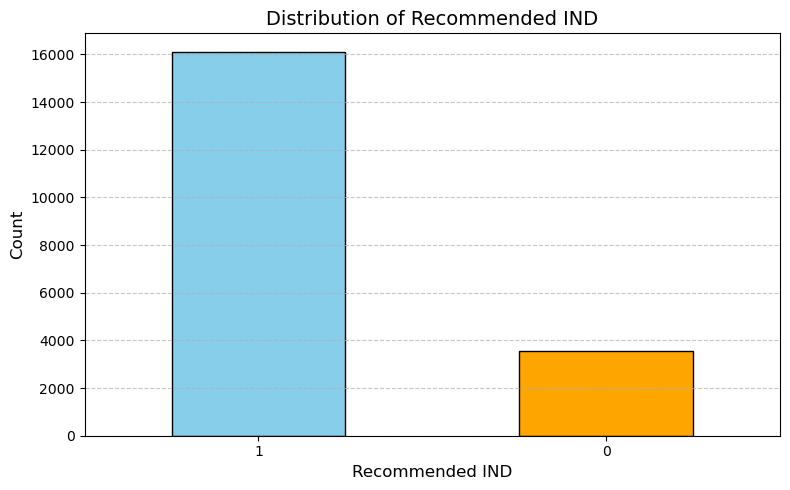

In [365]:
# Plot the distribution of the 'Recommended IND' column
if 'Recommended IND' in df.columns:
    plt.figure(figsize=(8, 5))
    df['Recommended IND'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
    plt.title('Distribution of Recommended IND', fontsize=14)
    plt.xlabel('Recommended IND', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'Recommended IND' column not found in the dataset.")

The bar chart highlights the imbalance in our target variable:  
- The majority of reviews (~16,000) are **recommended** (`1`).  
- A smaller portion (~3,600) are **not recommended** (`0`).  

This confirms that the dataset is skewed toward positive recommendations (about 4:1 ratio).  
We’ll need to keep this in mind when evaluating models, as accuracy alone may not fully reflect performance.  

With the target variable examined and validated, we can now move on to **Question 1** and compare different feature representations with machine learning models.  

### 3.2 Question 1 — Which representation performs best?

#### 3.2.1 Baseline Models Experiement

With the target validated, we now ask:  
**Which feature representation from Task 2 works best with our models?**  

We test three setups:  
- **Bag-of-Words (Count vectors)**  
- **Unweighted FastText embeddings**  
- **TF-IDF Weighted FastText embeddings**  

To handle class imbalance, we evaluate with multiple metrics (Accuracy, F1, ROC-AUC, Balanced Accuracy) under **Stratified 5-fold CV**.  
We also extract the target vector `y` and confirm its shape and positive rate.

In [366]:
RANDOM_STATE = 42
N_FOLDS = 5

# Use multiple metrics — accuracy alone can be misleading under imbalance
scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc": "roc_auc",
    "bacc": "balanced_accuracy"
}

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Target vector (ensure 0/1 int)
y = df["Recommended IND"].astype(int).to_numpy()
print("y shape:", y.shape, " | pos_rate:", np.mean(y).round(4))

y shape: (19652,)  | pos_rate: 0.8181


Next, we load the feature representations generated in **Task 2**.  
- **BoW (Count vectors)** are stored in `count_vectors.txt` (sparse format).  
- **Unweighted FastText embeddings** in `unweighted_vectors.txt`.  
- **TF-IDF Weighted FastText embeddings** in `weighted_vectors.txt`.  

We define helper functions to parse these files into proper matrices (sparse for BoW, dense for embeddings).  
After loading, we check the shapes of all three feature sets and ensure they align with the target vector `y`.

In [367]:
VOCAB_PATH = "../output/vocab.txt"
COUNT_VECTORS_PATH = "../output/count_vectors.txt"
UNW_PATH = "../output/unweighted_vectors.txt"
W_PATH   = "../output/weighted_vectors.txt"

# Load vocab size
with open(VOCAB_PATH, "r") as f:
    vocab_size = sum(1 for _ in f)
print("Vocab size:", vocab_size)

def load_sparse_counts(path, n_features):
    # Parse lines like: "#12,3:2,10:1,41:4"
    indices = []
    indptr = [0]
    data = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            # parts[0] is like "#12"
            for kv in parts[1:]:
                k, v = kv.split(":")
                indices.append(int(k))
                data.append(float(v))
            indptr.append(len(indices))
    X = csr_matrix((np.array(data, dtype=np.float32),
                    np.array(indices, dtype=np.int32),
                    np.array(indptr, dtype=np.int32)),
                   shape=(len(indptr)-1, n_features))
    return X

def load_dense_vectors(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            # "#idx,val1,val2,..."
            line = line.strip()
            comma = line.find(",")
            vec_str = line[comma+1:]
            rows.append([float(x) for x in vec_str.split(",")])
    return np.asarray(rows, dtype=np.float32)

# Load all three
X_bow = load_sparse_counts(COUNT_VECTORS_PATH, vocab_size)
X_unw = load_dense_vectors(UNW_PATH)
X_w   = load_dense_vectors(W_PATH)

print("Shapes -> BoW:", X_bow.shape, " | Unweighted:", X_unw.shape, " | Weighted:", X_w.shape)

# Sanity: all representations must align in rows with y
assert X_bow.shape[0] == y.shape[0] == X_unw.shape[0] == X_w.shape[0], "Row mismatch among features/target."

Vocab size: 6548
Shapes -> BoW: (19652, 6548)  | Unweighted: (19652, 300)  | Weighted: (19652, 300)


Before testing real models, we establish a **baseline** using a `DummyClassifier` that always predicts the most frequent class.  
This gives us a reference point: any meaningful model should perform better than this trivial strategy.  

We evaluate the dummy model with the same cross-validation setup and metrics (Accuracy, F1, ROC-AUC, Balanced Accuracy) to provide a fair comparison. 

In [368]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
base_res = cross_validate(baseline, X_bow, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

pd.DataFrame({
    "metric": list(scoring.keys()),
    "mean": [base_res[f"test_{k}"].mean() for k in scoring.keys()],
    "std":  [base_res[f"test_{k}"].std()  for k in scoring.keys()],
}).set_index("metric")

,mean,std
metric,,
acc,0.818085,0.000023
f1,0.899941,0.000014
roc,0.500000,0.000000
bacc,0.500000,0.000000


The baseline model achieves **81.8% accuracy**, which simply reflects the majority class rate in the dataset.  
However, its **ROC-AUC (0.5)** and **Balanced Accuracy (0.5)** show it has no real predictive power.  
The **F1 score (0.90)** is also misleading here, as it comes entirely from predicting the majority class.  

This confirms that accuracy and F1 alone can be deceptive under imbalance — stronger models need to show gains in ROC-AUC and Balanced Accuracy.

Next, we evaluate a stronger baseline model: **Logistic Regression** with class weights set to `"balanced"`.  
This adjustment compensates for the skewed class distribution by giving more weight to the minority class.  

We test Logistic Regression on all three feature sets:  
- **BoW (Count vectors)** — used directly without scaling.  
- **Unweighted embeddings** — scaled before training.  
- **TF-IDF Weighted embeddings** — also scaled before training.  

Each pipeline is run with 5-fold cross-validation, and we record the mean and standard deviation for all evaluation metrics.

In [369]:
logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipelines per feature set
pipe_bow = Pipeline([
    ("clf", logreg)  # no scaler for sparse BoW
])

pipe_unw = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", logreg)
])

pipe_w = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", logreg)
])

def eval_pipe(name, pipe, X, y):
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {
        "Feature set": name,
        **{f"mean_{m}": res[f"test_{m}"].mean() for m in scoring.keys()},
        **{f"std_{m}":  res[f"test_{m}"].std()  for m in scoring.keys()},
    }
    return row

results = []
results.append(eval_pipe("BoW (Count)",             pipe_bow, X_bow, y))
results.append(eval_pipe("Emb (Unweighted Avg)",    pipe_unw, X_unw, y))
results.append(eval_pipe("Emb (TF-IDF Weighted)",   pipe_w,   X_w,   y))

df_q1 = pd.DataFrame(results).sort_values("mean_f1", ascending=False).reset_index(drop=True)
df_q1

,Feature set,mean_acc,mean_f1,mean_roc,mean_bacc,std_acc,std_f1,std_roc,std_bacc
0,BoW (Count),0.849634,0.904821,0.888111,0.807387,0.005688,0.003916,0.005595,0.005601
1,Emb (Unweighted Avg),0.795950,0.864852,0.870756,0.791652,0.008911,0.006890,0.003354,0.008212
2,Emb (TF-IDF Weighted),0.784349,0.856635,0.860131,0.778144,0.010062,0.007716,0.004239,0.008550


The results show clear differences across feature representations:  

- **BoW (Count)** performs best overall, with the highest **F1 (0.905)** and **ROC-AUC (0.888)**, while also maintaining strong balanced accuracy (~0.81).  
- **Unweighted embeddings** achieve decent performance (**F1 = 0.865**, **ROC-AUC = 0.871**) but fall short compared to BoW.  
- **TF-IDF weighted embeddings** perform slightly worse than unweighted, with **F1 = 0.857** and **ROC-AUC = 0.860**.  

Overall, Logistic Regression favors the **BoW representation**, which outperforms embedding-based approaches on this dataset.

To complement Logistic Regression, we now test a **Linear Support Vector Machine (LinearSVC)** with class weights set to `"balanced"`.  
Like before, we run experiments on all three feature sets:  

- **BoW (Count vectors)** — directly used without scaling.  
- **Unweighted embeddings** — scaled before training.  
- **TF-IDF Weighted embeddings** — scaled before training.  

We apply 5-fold cross-validation and collect the same evaluation metrics to compare against the Logistic Regression results.

In [370]:
svm = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE)

pipe_bow_svm = Pipeline([("clf", svm)])
pipe_unw_svm = Pipeline([("scaler", StandardScaler()), ("clf", svm)])
pipe_w_svm   = Pipeline([("scaler", StandardScaler()), ("clf", svm)])

svm_rows = []
svm_rows.append(eval_pipe("BoW (Count) + SVM",           pipe_bow_svm, X_bow, y))
svm_rows.append(eval_pipe("Emb (Unweighted Avg) + SVM",  pipe_unw_svm, X_unw, y))
svm_rows.append(eval_pipe("Emb (TF-IDF Weighted) + SVM", pipe_w_svm,   X_w,   y))

df_q1_svm = pd.DataFrame(svm_rows).sort_values("mean_f1", ascending=False).reset_index(drop=True)
df_q1_svm

,Feature set,mean_acc,mean_f1,mean_roc,mean_bacc,std_acc,std_f1,std_roc,std_bacc
0,BoW (Count) + SVM,0.835691,0.896807,0.850525,0.770806,0.002954,0.002149,0.005672,0.007464
1,Emb (Unweighted Avg) + SVM,0.794322,0.863679,0.870790,0.790113,0.008221,0.006389,0.003553,0.008167
2,Emb (TF-IDF Weighted) + SVM,0.783534,0.855966,0.860363,0.778082,0.010962,0.008438,0.004387,0.009002


The Linear SVM results show a similar trend to Logistic Regression:  

- **BoW (Count)** again comes out on top, with the highest **F1 (0.897)** and strong accuracy (~0.836), though its ROC-AUC (0.851) is lower than Logistic Regression.  
- **Unweighted embeddings** achieve competitive **ROC-AUC (0.871)**, nearly matching their Logistic Regression performance.  
- **TF-IDF weighted embeddings** perform slightly worse, with **F1 = 0.856** and **ROC-AUC = 0.860**.  

Overall, SVM reinforces the finding that **BoW is the strongest representation**, while embeddings (especially unweighted) still perform reasonably well but lag behind.

To see if oversampling can help, we apply **SMOTE (Synthetic Minority Oversampling Technique)** on the minority class before training Logistic Regression.  
Unlike the earlier balanced-class-weight approach, this version of Logistic Regression uses **no class weights** and instead relies on SMOTE to balance the training data.  
We test this setup on the **Unweighted FastText embeddings** and evaluate it with the same cross-validation and metrics as before.

In [371]:
logreg_smote = LogisticRegression(
    max_iter=2000, class_weight=None, random_state=RANDOM_STATE, n_jobs=-1
)

pipe_unw_smote = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", logreg_smote)
])

res_smote = cross_validate(pipe_unw_smote, X_unw, y, cv=cv, scoring=scoring, n_jobs=-1)
pd.DataFrame({
    "metric": list(scoring.keys()),
    "mean": [res_smote[f"test_{k}"].mean() for k in scoring.keys()],
    "std":  [res_smote[f"test_{k}"].std()  for k in scoring.keys()],
}).set_index("metric")

,mean,std
metric,,
acc,0.801802,0.007080
f1,0.869802,0.005399
roc,0.868127,0.004110
bacc,0.788377,0.006397


The SMOTE-based Logistic Regression achieves **Accuracy = 80.2%**, **F1 = 0.870**, and **ROC-AUC = 0.868**, with **Balanced Accuracy = 0.788**.  
Compared to the class-weighted Logistic Regression results, the scores are similar but not clearly better — SMOTE provides only a modest benefit.  
This suggests that while SMOTE can balance the classes, the **class-weighting strategy is already effective**, and additional oversampling does not significantly improve performance here.

To make the results easier to compare, we tidy up the outputs from both **Logistic Regression** and **Linear SVM**.  
We standardize the column names, keep only the key metrics (F1, ROC-AUC, Balanced Accuracy, Accuracy), and merge everything into a single table.  

This combined view lets us directly compare how each feature representation performs across the two models.

In [372]:
def tidy(df, model_name):
    use = df.copy()
    use.insert(1, "Model", model_name)
    # Normalize possible column names
    if "mean_roc" in use.columns and "mean_roc_auc" not in use.columns:
        use = use.rename(columns={"mean_roc": "mean_roc_auc"})
    # Keep only columns that exist
    keep_cols = ["Feature set", "Model", "mean_f1", "mean_roc_auc", "mean_bacc", "mean_acc"]
    keep_cols = [c for c in keep_cols if c in use.columns]
    return use[keep_cols]

tbl = pd.concat(
    [
        tidy(df_q1, "LogReg (balanced)"),
        tidy(df_q1_svm, "LinearSVC (balanced)"),
    ],
    ignore_index=True,
)

# Round for neatness
num_cols = [c for c in tbl.columns if c.startswith("mean_")]
tbl[num_cols] = tbl[num_cols].round(4)

# Sort by model then F1 desc if available
sort_cols = ["Model"] + ([ "mean_f1" ] if "mean_f1" in tbl.columns else [])
tbl = tbl.sort_values(sort_cols, ascending=[True, False] if sort_cols else True).reset_index(drop=True)
tbl

,Feature set,Model,mean_f1,mean_roc_auc,mean_bacc,mean_acc
0,BoW (Count) + SVM,LinearSVC (balanced),0.8968,0.8505,0.7708,0.8357
1,Emb (Unweighted Avg) + SVM,LinearSVC (balanced),0.8637,0.8708,0.7901,0.7943
2,Emb (TF-IDF Weighted) + SVM,LinearSVC (balanced),0.8560,0.8604,0.7781,0.7835
3,BoW (Count),LogReg (balanced),0.9048,0.8881,0.8074,0.8496
4,Emb (Unweighted Avg),LogReg (balanced),0.8649,0.8708,0.7917,0.7960
5,Emb (TF-IDF Weighted),LogReg (balanced),0.8566,0.8601,0.7781,0.7843


This summary table confirms the earlier trends:  

- **BoW (Count)** remains the strongest representation overall.  
  - With **Logistic Regression**, it achieves the best balance of metrics (**F1 = 0.905**, **ROC-AUC = 0.888**, **Balanced Accuracy = 0.807**).  
  - With **SVM**, BoW still performs well (**F1 = 0.897**), though its ROC-AUC is lower than with Logistic Regression.  

- **Unweighted embeddings** are competitive in terms of ROC-AUC (~0.871 for both models) but slightly weaker on F1 and accuracy.  

- **TF-IDF weighted embeddings** consistently trail behind unweighted embeddings, regardless of model.  

Overall, **BoW paired with Logistic Regression (balanced)** gives the most robust performance, while embeddings provide decent alternatives but do not surpass the simpler BoW representation.

To compare strategies for handling class imbalance, we directly test **Logistic Regression with class weights balanced** against **Logistic Regression with SMOTE oversampling**.  
Both are evaluated on the **Unweighted FastText embeddings** using the same cross-validation and metrics.  
This lets us see whether oversampling provides any advantage over the simpler class-weight adjustment.  

In [373]:
# Logistic Regression with class_weight balanced (already trained)
res_balanced = cross_validate(
    pipe_unw, X_unw, y, cv=cv, scoring=scoring, n_jobs=-1
)

# Logistic Regression + SMOTE (already defined as pipe_unw_smote)
res_smote = cross_validate(
    pipe_unw_smote, X_unw, y, cv=cv, scoring=scoring, n_jobs=-1
)

# Build comparison table
comp = pd.DataFrame({
    "metric": list(scoring.keys()),
    "Balanced (mean)": [res_balanced[f"test_{m}"].mean() for m in scoring],
    "Balanced (std)":  [res_balanced[f"test_{m}"].std()  for m in scoring],
    "SMOTE (mean)":    [res_smote[f"test_{m}"].mean()    for m in scoring],
    "SMOTE (std)":     [res_smote[f"test_{m}"].std()     for m in scoring],
})

comp = comp.round(4)
comp

,metric,Balanced (mean),Balanced (std),SMOTE (mean),SMOTE (std)
0,acc,0.7960,0.0089,0.8018,0.0071
1,f1,0.8649,0.0069,0.8698,0.0054
2,roc,0.8708,0.0034,0.8681,0.0041
3,bacc,0.7917,0.0082,0.7884,0.0064


The comparison shows very similar results:  

- **Balanced weights**: F1 = 0.865, ROC-AUC = 0.871, Balanced Accuracy = 0.792  
- **SMOTE**: F1 = 0.870, ROC-AUC = 0.868, Balanced Accuracy = 0.788  

SMOTE gives a slight bump in accuracy and F1, but its ROC-AUC and balanced accuracy are slightly worse.  
Overall, the two approaches perform nearly the same, suggesting that **class weighting alone is already sufficient**, and SMOTE does not add a clear benefit for this dataset.

#### 3.2.2 Additional Models Experiment

Before experimenting with additional models, we reset the evaluation setup for clarity:  

- Define the same metrics (**Accuracy, F1, ROC-AUC, Balanced Accuracy**)  
- Use **Stratified 5-fold CV** with a fixed random seed for reproducibility  
- Run sanity checks to ensure all three feature matrices (BoW, Unweighted, Weighted) align with the target vector `y`

In [374]:
RANDOM_STATE = 42
N_FOLDS = 5

scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "bacc": "balanced_accuracy",
}
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Sanity checks
assert X_bow.shape[0] == y.shape[0] == X_unw.shape[0] == X_w.shape[0], "Rows mismatch among features/target."
print("Shapes OK -> BoW:", X_bow.shape, "| Unweighted:", X_unw.shape, "| Weighted:", X_w.shape, "| y:", y.shape)

Shapes OK -> BoW: (19652, 6548) | Unweighted: (19652, 300) | Weighted: (19652, 300) | y: (19652,)


The output confirms that all matrices have consistent shapes, so we can safely proceed with further experiments.

To streamline experiments with multiple classifiers, we define a helper function `evaluate_model`.  
It takes the experiment name, a pipeline, and a feature set, then runs **5-fold cross-validation** with our chosen metrics.  

The function returns a summary row containing the mean and standard deviation for each metric, making it easier to compare models later.

In [375]:
def evaluate_model(name, pipeline, X, y, *, cv=cv, scoring=scoring):
    res = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {"Exp": name}
    for m in scoring:
        row[f"{m}_mean"] = float(np.mean(res[f"test_{m}"]))
        row[f"{m}_std"]  = float(np.std(res[f"test_{m}"]))
    return row

We now define a broader set of models to compare across the three feature representations.  

- **Sparse-friendly (BoW)**  
  - Logistic Regression (balanced)  
  - Linear SVM (balanced)  
  - Multinomial Naive Bayes  
  - Random Forest (balanced)  

- **Dense-friendly (Embeddings)**  
  - Logistic Regression (balanced)  
  - Linear SVM (balanced)  
  - Histogram-based Gradient Boosting (balanced)  
  - Multi-Layer Perceptron (MLP) with 128 hidden units  

This setup allows us to test both linear and non-linear models, covering simple baselines through more complex learners.

In [376]:
# Sparse-friendly (BoW)
models_bow = {
    "LogReg (balanced)": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    "LinearSVC (balanced)": LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    "MultinomialNB": MultinomialNB(),
    "RandomForest (balanced)": RandomForestClassifier(
        n_estimators=250, max_depth=None, class_weight="balanced",
        n_jobs=-1, random_state=RANDOM_STATE
    ),
}

# Dense-friendly (Embeddings)
models_dense = {
    "LogReg (balanced)": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    "LinearSVC (balanced)": LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    "HistGB (balanced)": HistGradientBoostingClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "MLP (128)": MLPClassifier(hidden_layer_sizes=(128,), max_iter=80, random_state=RANDOM_STATE),
}

With the model set defined, we now run each classifier across all feature representations.  

- For **BoW**, we keep the sparse format and feed it directly into the models.  
- For **embeddings**, we scale the dense vectors before training.  

Using the `evaluate_model` helper, we collect the mean and standard deviation for each metric under 5-fold CV.  
Finally, we combine the results into a single dataframe and sort by **F1 score** to highlight the top-performing setups.

In [377]:
results = []

# BoW: no scaler (keep sparse)
for name, clf in models_bow.items():
    pipe = Pipeline([("clf", clf)])
    results.append(evaluate_model(f"{name} + BoW", pipe, X_bow, y))

# Embeddings: scale first (dense)
for name, clf in models_dense.items():
    pipe_unw = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    pipe_w   = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    results.append(evaluate_model(f"{name} + Emb-Unweighted", pipe_unw, X_unw, y))
    results.append(evaluate_model(f"{name} + Emb-WeightedTFIDF", pipe_w,   X_w,   y))

df_all = pd.DataFrame(results)
metric_cols = [c for c in df_all.columns if c.endswith("_mean")]
df_all_sorted = df_all.sort_values("f1_mean", ascending=False).reset_index(drop=True)
df_all_sorted[["Exp"] + metric_cols].round(4)

,Exp,acc_mean,f1_mean,roc_auc_mean,bacc_mean
0,MultinomialNB + BoW,0.8742,0.9229,0.8995,0.7929
1,RandomForest (balanced) + BoW,0.8594,0.9193,0.8906,0.6492
2,MLP (128) + Emb-Unweighted,0.8440,0.9061,0.8378,0.7108
3,LogReg (balanced) + BoW,0.8496,0.9048,0.8881,0.8074
4,MLP (128) + Emb-WeightedTFIDF,0.8389,0.9029,0.8303,0.7055
5,LinearSVC (balanced) + BoW,0.8357,0.8968,0.8505,0.7708
6,HistGB (balanced) + Emb-WeightedTFIDF,0.8121,0.8817,0.8330,0.7359
7,HistGB (balanced) + Emb-Unweighted,0.8125,0.8813,0.8422,0.7449
8,LogReg (balanced) + Emb-Unweighted,0.7960,0.8649,0.8708,0.7917
9,LinearSVC (balanced) + Emb-Unweighted,0.7943,0.8637,0.8708,0.7901


The extended comparison highlights some interesting patterns:  

- **Best overall**: **Multinomial Naive Bayes with BoW** achieves the top scores, with the highest **F1 (0.923)** and **ROC-AUC (0.900)**, making it the standout performer.  
- **Close runner-up**: **Random Forest with BoW** also performs strongly (**F1 = 0.919**, **ROC-AUC = 0.891**), though its **Balanced Accuracy (0.649)** is much lower, indicating it struggles more with the minority class.  
- **Neural models**: The **MLP with embeddings** performs better than Logistic Regression and SVM on dense inputs (**F1 ~0.906 unweighted, 0.903 weighted**), suggesting non-linear models can leverage embeddings more effectively.  
- **Linear models**: Logistic Regression and Linear SVM again confirm that **BoW works best for them**, while embedding-based inputs lag behind.  
- **Histogram Gradient Boosting** achieves reasonable results with embeddings (**F1 ~0.882**) but does not surpass the top BoW-based models.  

**Conclusion:** For this dataset, **BoW-based models clearly outperform embedding-based ones**, with **Naive Bayes** and **Random Forest** showing especially strong results. Among embeddings, **MLP** provides the best use of dense representations, though still below BoW.

To dig deeper into imbalance handling, we directly compare **Logistic Regression with balanced class weights** against **Logistic Regression with SMOTE oversampling** on the unweighted embeddings.  

We evaluate both under the same 5-fold CV setup and compute the **difference (Δ)** in performance metrics (SMOTE − Balanced).  
This makes it easy to see whether oversampling provides any clear advantage over class weighting.

In [378]:
logreg_bal = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)
pipe_bal_unw = Pipeline([("scaler", StandardScaler()), ("clf", logreg_bal)])

logreg_plain = LogisticRegression(max_iter=2000, class_weight=None, n_jobs=-1, random_state=RANDOM_STATE)
pipe_smote_unw = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", logreg_plain),
])

res_bal = cross_validate(pipe_bal_unw, X_unw, y, cv=cv, scoring=scoring, n_jobs=-1)
res_smt = cross_validate(pipe_smote_unw, X_unw, y, cv=cv, scoring=scoring, n_jobs=-1)

comp = pd.DataFrame({
    "metric": list(scoring.keys()),
    "Balanced_mean": [res_bal[f"test_{m}"].mean() for m in scoring],
    "Balanced_std":  [res_bal[f"test_{m}"].std()  for m in scoring],
    "SMOTE_mean":    [res_smt[f"test_{m}"].mean() for m in scoring],
    "SMOTE_std":     [res_smt[f"test_{m}"].std()  for m in scoring],
}).round(4)

# Add delta columns (SMOTE - Balanced)
for m in scoring:
    comp[f"Δ_{m}"] = (comp[f"SMOTE_mean"] - comp[f"Balanced_mean"]).round(4)

comp

,metric,Balanced_mean,Balanced_std,SMOTE_mean,SMOTE_std,Δ_acc,Δ_f1,Δ_roc_auc,Δ_bacc
0,acc,0.7960,0.0089,0.8018,0.0071,0.0058,0.0058,0.0058,0.0058
1,f1,0.8649,0.0069,0.8698,0.0054,0.0049,0.0049,0.0049,0.0049
2,roc_auc,0.8708,0.0034,0.8681,0.0041,-0.0027,-0.0027,-0.0027,-0.0027
3,bacc,0.7917,0.0082,0.7884,0.0064,-0.0033,-0.0033,-0.0033,-0.0033


The comparison shows only minor differences between class weighting and SMOTE:  

- **Accuracy and F1**: SMOTE gives a small boost (+0.006 in both).  
- **ROC-AUC and Balanced Accuracy**: slightly lower with SMOTE (−0.003).  

Overall, the two strategies perform almost identically.  
Class weighting is already effective, and SMOTE does not provide a clear advantage — the small gains in accuracy/F1 are offset by small drops in ROC-AUC and balanced accuracy.

We repeat the same comparison — **Logistic Regression with balanced class weights** vs **Logistic Regression with SMOTE** — but this time using the **TF-IDF Weighted FastText embeddings**.  

The setup is identical to the unweighted case, and we again calculate the **Δ (SMOTE − Balanced)** for each metric to see if oversampling provides any consistent benefit with this feature set.

In [379]:
pipe_bal_w = Pipeline([("scaler", StandardScaler()), ("clf", logreg_bal)])
pipe_smote_w = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", logreg_plain),
])

res_bal_w = cross_validate(pipe_bal_w, X_w, y, cv=cv, scoring=scoring, n_jobs=-1)
res_smt_w = cross_validate(pipe_smote_w, X_w, y, cv=cv, scoring=scoring, n_jobs=-1)

comp_w = pd.DataFrame({
    "metric": list(scoring.keys()),
    "Balanced_mean": [res_bal_w[f"test_{m}"].mean() for m in scoring],
    "Balanced_std":  [res_bal_w[f"test_{m}"].std()  for m in scoring],
    "SMOTE_mean":    [res_smt_w[f"test_{m}"].mean() for m in scoring],
    "SMOTE_std":     [res_smt_w[f"test_{m}"].std()  for m in scoring],
}).round(4)

for m in scoring:
    comp_w[f"Δ_{m}"] = (comp_w[f"SMOTE_mean"] - comp_w[f"Balanced_mean"]).round(4)

comp_w

,metric,Balanced_mean,Balanced_std,SMOTE_mean,SMOTE_std,Δ_acc,Δ_f1,Δ_roc_auc,Δ_bacc
0,acc,0.7843,0.0101,0.7941,0.0105,0.0098,0.0098,0.0098,0.0098
1,f1,0.8566,0.0077,0.8645,0.0081,0.0079,0.0079,0.0079,0.0079
2,roc_auc,0.8601,0.0042,0.8572,0.0044,-0.0029,-0.0029,-0.0029,-0.0029
3,bacc,0.7781,0.0085,0.7779,0.0067,-0.0002,-0.0002,-0.0002,-0.0002


For the **TF-IDF Weighted embeddings**, the results mirror the unweighted case:  

- **Accuracy and F1**: SMOTE shows small improvements (+0.010 in accuracy, +0.008 in F1).  
- **ROC-AUC and Balanced Accuracy**: slightly worse with SMOTE (−0.003 and −0.0002, respectively).  

Overall, the differences remain marginal.  
As with the unweighted embeddings, **class weighting alone is sufficient**, and SMOTE does not provide a consistent or meaningful advantage here.

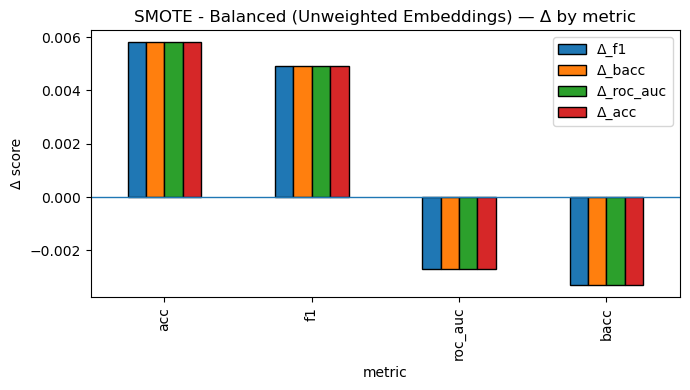

In [380]:
plot_df = comp.set_index("metric")[["Δ_f1", "Δ_bacc", "Δ_roc_auc", "Δ_acc"]]
ax = plot_df.plot(kind="bar", figsize=(7,4), edgecolor="black")
ax.axhline(0, linewidth=1)
ax.set_title("SMOTE - Balanced (Unweighted Embeddings) — Δ by metric")
ax.set_ylabel("Δ score")
plt.tight_layout()
plt.show()

The bar chart visualizes the effect of SMOTE compared to class weighting on unweighted embeddings.  

- **Accuracy and F1**: both see slight gains with SMOTE.  
- **ROC-AUC and Balanced Accuracy**: both decrease a little under SMOTE.  

The changes are very small in all cases, reinforcing that **SMOTE does not meaningfully improve performance** over using class weights alone.

In [381]:
leaderboard = df_all_sorted[["Exp", "f1_mean", "roc_auc_mean", "bacc_mean", "acc_mean"]].round(4)
leaderboard

,Exp,f1_mean,roc_auc_mean,bacc_mean,acc_mean
0,MultinomialNB + BoW,0.9229,0.8995,0.7929,0.8742
1,RandomForest (balanced) + BoW,0.9193,0.8906,0.6492,0.8594
2,MLP (128) + Emb-Unweighted,0.9061,0.8378,0.7108,0.8440
3,LogReg (balanced) + BoW,0.9048,0.8881,0.8074,0.8496
4,MLP (128) + Emb-WeightedTFIDF,0.9029,0.8303,0.7055,0.8389
5,LinearSVC (balanced) + BoW,0.8968,0.8505,0.7708,0.8357
6,HistGB (balanced) + Emb-WeightedTFIDF,0.8817,0.8330,0.7359,0.8121
7,HistGB (balanced) + Emb-Unweighted,0.8813,0.8422,0.7449,0.8125
8,LogReg (balanced) + Emb-Unweighted,0.8649,0.8708,0.7917,0.7960
9,LinearSVC (balanced) + Emb-Unweighted,0.8637,0.8708,0.7901,0.7943


To wrap up **Question 1**, we build a leaderboard of all models and feature representations, sorted by **F1 score**.  
This gives a clear view of which combinations perform best across multiple metrics.  

**Key takeaways from the leaderboard:**  
- **Top performer:** Multinomial Naive Bayes with BoW (**F1 = 0.923, ROC-AUC = 0.900**).  
- **Close second:** Random Forest with BoW (**F1 = 0.919**), though its balanced accuracy (0.649) is weaker, showing less reliability on the minority class.  
- **Strong embeddings:** MLP on unweighted embeddings (**F1 = 0.906**) and weighted embeddings (**F1 = 0.903**) outperform linear models with embeddings, but still trail BoW methods.  
- **Linear models (LogReg, SVM):** Consistently favor BoW, achieving solid but not top results.  
- **Histogram Gradient Boosting:** Reasonable with embeddings (**F1 ~0.88**), but again below the BoW-based models.  

**Conclusion for Q1:**  
Bag-of-Words is the most effective representation for this dataset, especially with simpler models like Naive Bayes and Random Forest.  
While embeddings paired with MLP show promise, they do not surpass BoW approaches.  
For handling class imbalance, **balanced class weights are sufficient**, with SMOTE offering no clear advantage.

#### 3.2.3 Summary  

In **Question 1**, we compared different feature representations and models to see which setup performs best for classifying clothing reviews.  

- **BoW representations** consistently outperformed embeddings, with **Multinomial Naive Bayes (F1 = 0.923)** and **Random Forest (F1 = 0.919)** leading the results.  
- **Logistic Regression and SVM** also favored BoW, achieving solid F1 scores (~0.90) but not surpassing Naive Bayes.  
- **Embedding-based models** worked better with non-linear classifiers like MLP, reaching F1 ≈ 0.906, though still below BoW methods.  
- **Imbalance handling:** Using `class_weight="balanced"` was already effective, while SMOTE offered only marginal changes and no consistent improvements.  

**Overall:** The simplest representation (BoW) with lightweight models (Naive Bayes, Random Forest) provided the strongest and most reliable performance.

### 3.3 Question 2 — Does more information help?

In Task 2, we focused only on the **review text** when generating feature representations.  
Now, we expand our investigation to see whether adding the **review title** improves classification performance.  

We compare three input settings:  
- **Title only**  
- **Text only** (baseline from Q1)  
- **Title + Text** (concatenated into a single document)  

Each input is tested across the same feature types (BoW, Unweighted embeddings, TF-IDF Weighted embeddings) and models, using the same evaluation setup as in Q1.  
This allows us to directly measure the contribution of Title information to model performance.

#### 3.3.1 Baseline Models Experiement

We first prepare the inputs for Q2.  
If `Title` exists, we clean it and **tokenize with the same regex** from Task 1 to stay consistent.  
We then build three text variants:

- **Title only** (`titles_clean`)  
- **Text only** (`texts_clean`, from Task 1 tokens)  
- **Title + Text** (`combo_clean`, concatenated and re-spaced)

A quick print verifies that the strings look correct before vectorizing.

In [382]:
# Reuse: df (processed.csv loaded), vocab, tokenizer/tokenize(), ft_model, idf_weights, cv, scoring, y
assert 'Recommended IND' in df.columns, "Target column not found."

In [383]:
# Use Title if available; otherwise fill with blanks (so code still runs)
if 'Title' in df.columns:
    titles_raw = df['Title'].fillna('').astype(str)
else:
    print("WARNING: 'Title' column not found in df; Title-only/Title+Text will be blank.")
    titles_raw = pd.Series([''] * len(df), index=df.index)

# Text corpus from your processed tokens (already cleaned in Task 1)
texts_clean = df['tokens_typo_fixed'].fillna('').astype(str)

# Tokenize title with the same regex rule to keep consistency
titles_clean = titles_raw.apply(lambda s: " ".join(tokenize(s)))

# Concatenate Title + Text (already space-separated tokens)
combo_clean = (titles_clean.str.cat(texts_clean, sep=" ").str.replace(r"\s+", " ", regex=True).str.strip())

# Quick sanity
print("Examples:\nTITLE ->", titles_clean.iloc[0][:100])
print("TEXT  ->", texts_clean.iloc[0][:100])
print("COMBO ->", combo_clean.iloc[0][:100])

Examples:
TITLE -> some major design flaws
TEXT  -> ['high', 'hope', 'wanted', 'work', 'initially', 'petite', 'usual', 'found', 'outrageously', 'fact', 
COMBO -> some major design flaws ['high', 'hope', 'wanted', 'work', 'initially', 'petite', 'usual', 'found', 


Next, we build feature matrices for the three **input variants** (Title, Text, Title+Text) across all **representation types**:

- **BoW (Count)**: reuse the fixed vocabulary from Task 1 to keep indices consistent.  
- **Unweighted embeddings**: mean of FastText vectors per document.  
- **TF-IDF weighted embeddings**: FastText vectors scaled by IDF learned from **Review Text** (same weights as in Task 2).

We then print the shapes to confirm that Title, Text, and Title+Text versions align with each other and with `y`.

In [384]:
# --- BoW (reuse the same vocabulary from Task 1, as required) ---
cv_bow = CountVectorizer(vocabulary=vocab)
X_title_bow = cv_bow.transform(titles_clean)
# You already have X_bow for Text-only; if not, uncomment:
# X_text_bow  = cv_bow.transform(texts_clean)
X_combo_bow = cv_bow.transform(combo_clean)

# --- Unweighted embeddings (mean of word vectors) ---
def doc_avg_embedding(doc_str):
    toks = tokenize(doc_str)
    vecs = [ft_model[t] for t in toks if t in ft_model]
    if not vecs:
        return np.zeros(ft_model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_title_unw = np.vstack([doc_avg_embedding(s) for s in titles_clean])
# You already have X_unw for Text-only
X_combo_unw = np.vstack([doc_avg_embedding(s) for s in combo_clean])

# --- TF-IDF weighted embeddings (uses IDF learned from Review Text) ---
def doc_tfidf_weighted_embedding(doc_str):
    toks = tokenize(doc_str)
    vec_sum, w_sum = None, 0.0
    for t in toks:
        if (t in ft_model) and (t in idf_weights):  # keep only tokens known to IDF from Review Text
            w = float(idf_weights[t])
            v = ft_model[t] * w
            vec_sum = v if vec_sum is None else (vec_sum + v)
            w_sum += w
    if (vec_sum is None) or (w_sum == 0.0):
        return np.zeros(ft_model.vector_size, dtype=np.float32)
    return (vec_sum / w_sum)

X_title_w = np.vstack([doc_tfidf_weighted_embedding(s) for s in titles_clean])
# You already have X_w for Text-only
X_combo_w = np.vstack([doc_tfidf_weighted_embedding(s) for s in combo_clean])

print("Shapes | BoW:", X_title_bow.shape, X_bow.shape, X_combo_bow.shape,
      "| Unw:", X_title_unw.shape, X_unw.shape, X_combo_unw.shape,
      "| W:", X_title_w.shape, X_w.shape, X_combo_w.shape)

Shapes | BoW: (19652, 6548) (19652, 6548) (19652, 6548) | Unw: (19652, 300) (19652, 300) (19652, 300) | W: (19652, 300) (19652, 300) (19652, 300)


We begin our Q2 experiments with a **Logistic Regression** model using `class_weight="balanced"`.  
This ensures that minority and majority classes are treated fairly during training.  

As before:  
- **BoW (Count vectors)** is used directly without scaling.  
- **Unweighted embeddings** are scaled before classification.  
- **TF-IDF Weighted embeddings** are also scaled.  

These pipelines set up a consistent baseline to evaluate the impact of adding **Title** information in the next steps.

In [385]:
logreg_bal = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=42)

pipe_bow = Pipeline([("clf", logreg_bal)])  # no scaler for sparse BoW
pipe_unw = Pipeline([("scaler", StandardScaler()), ("clf", logreg_bal)])
pipe_w   = Pipeline([("scaler", StandardScaler()), ("clf", logreg_bal)])

We now evaluate **Logistic Regression (balanced)** across all three input settings:  
- **Title only**  
- **Text only**  
- **Title + Text**  

For each input, we test the three representation types (BoW, Unweighted embeddings, TF-IDF Weighted embeddings).  
We use a helper function `cv_means` to run 5-fold CV and return the mean scores for all metrics.  

The results are collected into a dataframe, rounded for readability, and sorted within each representation by **F1 score**.  
This allows us to directly compare the effect of adding Title information to the models.

In [386]:
def cv_means(pipe, X, y):
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return {f"mean_{m}": float(np.mean(res[f"test_{m}"])) for m in scoring}

rows = []
# BoW
rows.append({"Rep":"BoW", "Input":"Title",      **cv_means(pipe_bow, X_title_bow, y)})
rows.append({"Rep":"BoW", "Input":"Text",       **cv_means(pipe_bow, X_bow,       y)})
rows.append({"Rep":"BoW", "Input":"Title+Text", **cv_means(pipe_bow, X_combo_bow, y)})

# Unweighted
rows.append({"Rep":"Unweighted", "Input":"Title",      **cv_means(pipe_unw, X_title_unw, y)})
rows.append({"Rep":"Unweighted", "Input":"Text",       **cv_means(pipe_unw, X_unw,       y)})
rows.append({"Rep":"Unweighted", "Input":"Title+Text", **cv_means(pipe_unw, X_combo_unw, y)})

# Weighted
rows.append({"Rep":"Weighted", "Input":"Title",      **cv_means(pipe_w, X_title_w, y)})
rows.append({"Rep":"Weighted", "Input":"Text",       **cv_means(pipe_w, X_w,       y)})
rows.append({"Rep":"Weighted", "Input":"Title+Text", **cv_means(pipe_w, X_combo_w, y)})

q2_results = pd.DataFrame(rows)
for c in [c for c in q2_results.columns if c.startswith("mean_")]:
    q2_results[c] = q2_results[c].round(4)

q2_results = q2_results.sort_values(["Rep","mean_f1"], ascending=[True, False]).reset_index(drop=True)
q2_results

,Rep,Input,mean_acc,mean_f1,mean_roc_auc,mean_bacc
0,BoW,Title+Text,0.8794,0.9243,0.9223,0.8439
1,BoW,Text,0.8496,0.9048,0.8881,0.8074
2,BoW,Title,0.8250,0.8857,0.8952,0.8190
3,Unweighted,Title+Text,0.8442,0.8987,0.9193,0.8420
4,Unweighted,Title,0.8314,0.8892,0.9078,0.8393
5,Unweighted,Text,0.7960,0.8649,0.8708,0.7917
6,Weighted,Title+Text,0.8247,0.8852,0.9026,0.8212
7,Weighted,Title,0.8048,0.8707,0.8752,0.8072
8,Weighted,Text,0.7843,0.8566,0.8601,0.7781


The results show that adding the **Title** information consistently improves performance across all representations:  

- **BoW**:  
  - **Title+Text** gives the best overall performance (**F1 = 0.924**, **ROC-AUC = 0.922**), a clear gain over **Text only (F1 = 0.905)**.  
  - **Title only** performs weaker than Text, but still provides reasonable scores (F1 = 0.886).  

- **Unweighted embeddings**:  
  - **Title+Text** also improves results (**F1 = 0.899**) compared to Text only (**F1 = 0.865**).  
  - Title alone performs slightly below Title+Text but still better than Text alone.  

- **TF-IDF Weighted embeddings**:  
  - The same pattern holds, with **Title+Text** (F1 = 0.885) outperforming Text only (**F1 = 0.857**).  
  - Title alone (F1 = 0.871) again shows better results than Text only.  

**Conclusion:** Incorporating **Title information** boosts classification performance in all cases, with the strongest gains seen in the **BoW model**. Title by itself is not as strong as Text, but when combined, it clearly enhances accuracy and F1.

To make the impact of **Title** more explicit, we calculate the **delta (Δ)** of each metric relative to the **Text-only baseline**.  

For each representation (BoW, Unweighted, Weighted):  
- We take the performance of **Text only** as the baseline.  
- We compute the difference (Δ) for **Title** and **Title+Text** across all metrics (F1, Balanced Accuracy, ROC-AUC, Accuracy).  

This highlights how much value Title information adds, either on its own or when combined with Text.

In [387]:
def deltas_vs_text(df):
    out = []
    for rep, grp in df.groupby("Rep"):
        # find the Text-only row as baseline
        base = grp.loc[grp["Input"]=="Text"].iloc[0]
        for _, row in grp.iterrows():
            d = {"Rep": rep, "Input": row["Input"]}
            for m in ["mean_f1","mean_bacc","mean_roc_auc","mean_acc"]:
                if m in row and m in base:
                    d[f"Δ_{m.replace('mean_','')}"] = (row[m] - base[m]).round(4)
            out.append(d)
    return pd.DataFrame(out)

q2_delta = deltas_vs_text(q2_results)
q2_delta

,Rep,Input,Δ_f1,Δ_bacc,Δ_roc_auc,Δ_acc
0,BoW,Title+Text,0.0195,0.0365,0.0342,0.0298
1,BoW,Text,0.0000,0.0000,0.0000,0.0000
2,BoW,Title,-0.0191,0.0116,0.0071,-0.0246
3,Unweighted,Title+Text,0.0338,0.0503,0.0485,0.0482
4,Unweighted,Title,0.0243,0.0476,0.0370,0.0354
5,Unweighted,Text,0.0000,0.0000,0.0000,0.0000
6,Weighted,Title+Text,0.0286,0.0431,0.0425,0.0404
7,Weighted,Title,0.0141,0.0291,0.0151,0.0205
8,Weighted,Text,0.0000,0.0000,0.0000,0.0000


The Δ table shows the performance change relative to **Text only**:  

- **BoW**:  
  - Adding Title to Text gives a modest boost (**+0.020 F1, +0.036 Balanced Accuracy, +0.034 ROC-AUC**).  
  - Title alone underperforms Text (**−0.019 F1**), confirming it’s not as informative by itself.  

- **Unweighted embeddings**:  
  - Title+Text provides the largest gains (**+0.034 F1, +0.050 Balanced Accuracy, +0.049 ROC-AUC**).  
  - Even Title alone improves results over Text-only (**+0.024 F1**).  

- **TF-IDF Weighted embeddings**:  
  - Similar trend: Title+Text outperforms Text-only (**+0.029 F1, +0.043 Balanced Accuracy, +0.043 ROC-AUC**).  
  - Title alone offers smaller but still positive improvements (**+0.014 F1**).  

**Summary:** Adding the Title consistently improves classification across all representations, with the strongest relative boost in **Unweighted embeddings**, followed by Weighted embeddings and BoW. Title on its own is weaker than Text, but still better than nothing.

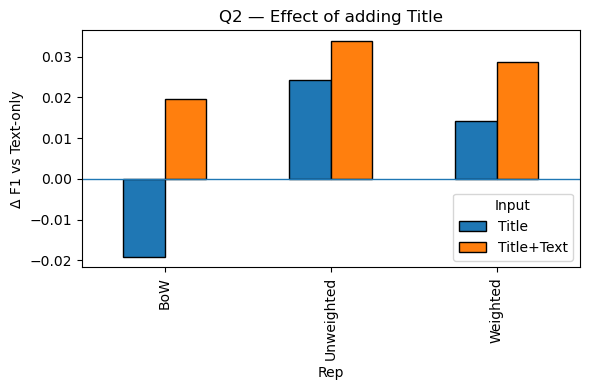

In [388]:
plot_df = q2_delta[q2_delta["Input"]!="Text"].pivot(index="Rep", columns="Input", values="Δ_f1")
ax = plot_df.plot(kind="bar", figsize=(6.0,4.0), edgecolor="black")
ax.axhline(0, linewidth=1)
ax.set_ylabel("Δ F1 vs Text-only")
ax.set_title("Q2 — Effect of adding Title")
plt.tight_layout()
plt.show()

The plot clearly shows how adding **Title** affects F1 compared to using **Text only**:  

- **BoW**: Title alone hurts performance (negative ΔF1), but Title+Text gives a small boost.  
- **Unweighted embeddings**: Adding Title produces the strongest improvements, especially when combined with Text (**ΔF1 ≈ +0.034**).  
- **Weighted embeddings**: Both Title and Title+Text help, with Title+Text again giving the larger gain.  

**Takeaway:** Title information is most valuable when combined with Text, consistently raising F1 across all representations — with the largest benefit seen in the **Unweighted embeddings**.  

#### 3.3.2 Additional Models Experiement

To ensure reproducibility, we **rebuild** all three input variants (Title, Text, Title+Text) and regenerate their feature matrices from scratch:

1) **Inputs** — clean/tokenize `Title`, keep `Text` from Task 1, and concatenate for `Title+Text`.  
2) **BoW** — vectorize with the **fixed Task 1 vocabulary** (keeps indices consistent).  
3) **Unweighted embeddings** — FastText mean per document.  
4) **TF-IDF weighted embeddings** — FastText vectors scaled by IDF learned from **Review Text**.

We then print shapes for (Title, Text, Title+Text) under each representation to confirm alignment before modeling.

In [389]:
# Inputs (recreate safely)
titles_raw = df['Title'].fillna('').astype(str) if 'Title' in df.columns else pd.Series(['']*len(df), index=df.index)
texts_clean = df['tokens_typo_fixed'].fillna('').astype(str)  # from Task 1
titles_clean = titles_raw.apply(lambda s: " ".join(tokenize(s)))
combo_clean = (titles_clean.str.cat(texts_clean, sep=" ")
               .str.replace(r"\s+", " ", regex=True).str.strip())

In [390]:
# BoW (fixed vocab from Task 1)
cv_bow = CountVectorizer(vocabulary=vocab)
X_title_bow = cv_bow.transform(titles_clean)
X_text_bow  = cv_bow.transform(texts_clean)   # (alias of your X_bow, rebuilt for completeness)
X_combo_bow = cv_bow.transform(combo_clean)

In [391]:
# Unweighted embeddings
def doc_avg_embedding(doc_str):
    toks = tokenize(doc_str)
    vecs = [ft_model[t] for t in toks if t in ft_model]
    return np.mean(vecs, axis=0) if vecs else np.zeros(ft_model.vector_size, dtype=np.float32)

X_title_unw = np.vstack([doc_avg_embedding(s) for s in titles_clean])
X_text_unw  = np.vstack([doc_avg_embedding(s) for s in texts_clean])    # (alias of X_unw)
X_combo_unw = np.vstack([doc_avg_embedding(s) for s in combo_clean])

In [392]:
# TF-IDF weighted embeddings (reuse idf_weights from Text)
def doc_tfidf_weighted_embedding(doc_str):
    toks = tokenize(doc_str); wsum = 0.0; acc = None
    for t in toks:
        if (t in ft_model) and (t in idf_weights):
            w = float(idf_weights[t]); v = ft_model[t] * w
            acc = v if acc is None else (acc + v); wsum += w
    return (acc / wsum) if (acc is not None and wsum>0) else np.zeros(ft_model.vector_size, dtype=np.float32)

X_title_w = np.vstack([doc_tfidf_weighted_embedding(s) for s in titles_clean])
X_text_w  = np.vstack([doc_tfidf_weighted_embedding(s) for s in texts_clean])   # (alias of X_w)
X_combo_w = np.vstack([doc_tfidf_weighted_embedding(s) for s in combo_clean])

In [393]:
print("BoW   :", X_title_bow.shape, X_text_bow.shape, X_combo_bow.shape)
print("Unw   :", X_title_unw.shape,  X_text_unw.shape,  X_combo_unw.shape)
print("TF-IDF:", X_title_w.shape,    X_text_w.shape,    X_combo_w.shape)

BoW   : (19652, 6548) (19652, 6548) (19652, 6548)
Unw   : (19652, 300) (19652, 300) (19652, 300)
TF-IDF: (19652, 300) (19652, 300) (19652, 300)


We now define the set of models to be tested in **Question 2**.  
As in Q1, we separate them into two groups depending on the representation type:  

- **Sparse-friendly (BoW)**:  
  - Logistic Regression (balanced)  
  - Linear SVM (balanced)  
  - Multinomial Naive Bayes  
  - Random Forest (balanced)  

- **Dense-friendly (Embeddings)**:  
  - Logistic Regression (balanced)  
  - Linear SVM (balanced)  
  - Histogram-based Gradient Boosting (balanced)  
  - Multi-Layer Perceptron (MLP, 128 hidden units)  

This mix covers both linear and non-linear models, ensuring a fair comparison of BoW vs embedding representations with Title, Text, and Title+Text inputs.

In [394]:
RANDOM_STATE = 42

# Sparse-friendly (BoW)
models_bow = {
    "LogReg (balanced)": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    "LinearSVC (balanced)": LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    "MultinomialNB": MultinomialNB(),
    "RandomForest (balanced)": RandomForestClassifier(
        n_estimators=250, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
    ),
}

# Dense-friendly (Embeddings)
models_dense = {
    "LogReg (balanced)": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    "LinearSVC (balanced)": LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    "HistGB (balanced)": HistGradientBoostingClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "MLP (128)": MLPClassifier(hidden_layer_sizes=(128,), max_iter=80, random_state=RANDOM_STATE),
}

To evaluate multiple models efficiently, we define a helper function `evaluate_pipeline`.  
It runs **cross-validation** on a given pipeline, collects all metric scores, and returns a summary row:  

- Includes the experiment name (`RepInputModel`)  
- Stores the **mean** and **standard deviation** for each metric (Accuracy, F1, ROC-AUC, Balanced Accuracy)  

This structure makes it easier to aggregate results across different representations, inputs, and models in a single dataframe.

In [395]:
def evaluate_pipeline(exp_name, pipe, X, y, cv=cv, scoring=scoring):
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {"RepInputModel": exp_name}
    for m in scoring:
        row[f"{m}_mean"] = float(np.mean(res[f"test_{m}"]))
        row[f"{m}_std"]  = float(np.std(res[f"test_{m}"]))
    return row

We now run **all models** across every **representation** (BoW, Unweighted, Weighted) and **input** (Title, Text, Title+Text).

- `run_block(...)` builds a pipeline per model, scaling only for dense embeddings.
- Each experiment is evaluated with 5-fold CV via `evaluate_pipeline`, and the results are appended to a list.
- We then unpack the composite experiment name into **Rep / Input / Model** and build a **leaderboard** sorted by **F1** (primary metric under imbalance), with **ROC-AUC** as a tiebreaker.

The table below shows the top results (rounded) for quick comparison.

We reuse the **model definitions** from Q1 and apply them to Q2.  
The models are grouped by representation type:  

- **Sparse-friendly (BoW):**  
  Logistic Regression (balanced), Linear SVM (balanced), Multinomial Naive Bayes, Random Forest (balanced).  

- **Dense-friendly (Embeddings):**  
  Logistic Regression (balanced), Linear SVM (balanced), Histogram Gradient Boosting (balanced), and MLP (128 hidden units).  

This ensures consistency in comparing performance across **Title**, **Text**, and **Title+Text** inputs for each representation.

In [396]:
results = []

# Helper to push rows
def run_block(rep, input_name, Xmat, model_dict, needs_scaler=False):
    for mname, clf in model_dict.items():
        if needs_scaler:
            pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
        else:
            pipe = Pipeline([("clf", clf)])
        tag = f"{rep} | {input_name} | {mname}"
        results.append(evaluate_pipeline(tag, pipe, Xmat, y))

# BoW (no scaler)
run_block("BoW", "Title",      X_title_bow, models_bow, needs_scaler=False)
run_block("BoW", "Text",       X_text_bow,  models_bow, needs_scaler=False)
run_block("BoW", "Title+Text", X_combo_bow, models_bow, needs_scaler=False)

# Unweighted (scale)
run_block("Unweighted", "Title",      X_title_unw, models_dense, needs_scaler=True)
run_block("Unweighted", "Text",       X_text_unw,  models_dense, needs_scaler=True)
run_block("Unweighted", "Title+Text", X_combo_unw, models_dense, needs_scaler=True)

# Weighted (scale)
run_block("Weighted", "Title",      X_title_w, models_dense, needs_scaler=True)
run_block("Weighted", "Text",       X_text_w,  models_dense, needs_scaler=True)
run_block("Weighted", "Title+Text", X_combo_w, models_dense, needs_scaler=True)

df_q2_all = pd.DataFrame(results)
# Split composite name for readability
df_q2_all[["Rep","Input","Model"]] = df_q2_all["RepInputModel"].str.split(" \| ", expand=True)
df_q2_all = df_q2_all.drop(columns=["RepInputModel"])

# Leaderboard by F1
cols = ["Rep","Input","Model","f1_mean","roc_auc_mean","bacc_mean","acc_mean"]
df_q2_all_leader = df_q2_all[cols].sort_values(["f1_mean","roc_auc_mean"], ascending=False).round(4).reset_index(drop=True)
df_q2_all_leader.head(20)

,Rep,Input,Model,f1_mean,roc_auc_mean,bacc_mean,acc_mean
0,BoW,Title+Text,MultinomialNB,0.9309,0.9306,0.8406,0.8887
1,BoW,Title+Text,RandomForest (balanced),0.9280,0.9247,0.6974,0.8758
2,Unweighted,Title,MLP (128),0.9267,0.9043,0.7777,0.8788
3,Unweighted,Title+Text,MLP (128),0.9258,0.9030,0.7757,0.8774
4,BoW,Title+Text,LogReg (balanced),0.9243,0.9223,0.8439,0.8794
5,BoW,Text,MultinomialNB,0.9229,0.8995,0.7929,0.8742
6,BoW,Title,MultinomialNB,0.9221,0.8889,0.6931,0.8666
7,Weighted,Title+Text,MLP (128),0.9197,0.8841,0.7546,0.8670
8,BoW,Text,RandomForest (balanced),0.9193,0.8906,0.6492,0.8594
9,Weighted,Title,MLP (128),0.9191,0.8652,0.7441,0.8655


The Q2 leaderboard highlights the value of **Title information** across different models and representations:  

- **Top performer:**  
  - **BoW + Title+Text with MultinomialNB** achieves the best overall scores (**F1 = 0.931, ROC-AUC = 0.931, Balanced Accuracy = 0.841**).  
  - This shows that combining Title with Text produces a clear improvement over Text alone.  

- **Other strong setups:**  
  - **BoW + Title+Text with Random Forest** (**F1 = 0.928**) and **Logistic Regression** (**F1 = 0.924**) also perform extremely well.  
  - **Unweighted embeddings + MLP** is the best among embedding models (**F1 ≈ 0.926 with Title, 0.926 with Title+Text**), confirming that neural models make better use of dense vectors.  

- **Comparisons to Text-only baselines:**  
  - MultinomialNB with **Text only** scored F1 = 0.923, while adding Title+Text pushed it to 0.931.  
  - Similarly, MLP on **Text only** embeddings had F1 = 0.906, but adding Title raised it to ~0.926.  

- **Balanced Accuracy patterns:**  
  - BoW + Logistic Regression and BoW + MultinomialNB deliver the best balance across both classes (Balanced Accuracy ≈ 0.84).  
  - Random Forest, while strong on F1, lags in Balanced Accuracy (0.697), indicating weaker minority-class sensitivity.  

**Conclusion:**  
Adding **Title information** improves performance across all settings, with the biggest gains seen in **BoW models** (especially MultinomialNB).  
Among embeddings, **MLP** benefits most from Title, but still does not surpass the top BoW methods.

To test imbalance handling in Q2, we compare **Logistic Regression (balanced class weights)** with **Logistic Regression + SMOTE oversampling**.  
We run this comparison on both **Unweighted** and **TF-IDF Weighted embeddings** for all three input settings (Title, Text, Title+Text).  

The helper `smote_compare_block` runs both pipelines, collects mean scores, and computes the **Δ (SMOTE − Balanced)** for each metric.  
This lets us see if oversampling adds value beyond class weighting when Title information is included.

In [397]:
logreg_bal = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)
logreg_nomw = LogisticRegression(max_iter=2000, class_weight=None, n_jobs=-1, random_state=RANDOM_STATE)

def smote_compare_block(rep, input_name, X_dense):
    pipe_bal = Pipeline([("scaler", StandardScaler()), ("clf", logreg_bal)])
    pipe_smt = ImbPipeline([("scaler", StandardScaler()),
                            ("smote", SMOTE(random_state=RANDOM_STATE)),
                            ("clf", logreg_nomw)])
    res_bal = cross_validate(pipe_bal, X_dense, y, cv=cv, scoring=scoring, n_jobs=-1)
    res_smt = cross_validate(pipe_smt, X_dense, y, cv=cv, scoring=scoring, n_jobs=-1)
    row = {"Rep":rep, "Input":input_name}
    for m in scoring:
        row[f"Balanced_{m}"] = float(np.mean(res_bal[f"test_{m}"]))
        row[f"SMOTE_{m}"]    = float(np.mean(res_smt[f"test_{m}"]))
        row[f"Δ_{m}"]        = row[f"SMOTE_{m}"] - row[f"Balanced_{m}"]
    return row

comp_rows = []
# Unweighted
comp_rows.append(smote_compare_block("Unweighted", "Title",      X_title_unw))
comp_rows.append(smote_compare_block("Unweighted", "Text",       X_text_unw))
comp_rows.append(smote_compare_block("Unweighted", "Title+Text", X_combo_unw))
# Weighted
comp_rows.append(smote_compare_block("Weighted", "Title",      X_title_w))
comp_rows.append(smote_compare_block("Weighted", "Text",       X_text_w))
comp_rows.append(smote_compare_block("Weighted", "Title+Text", X_combo_w))

q2_smote_comp = pd.DataFrame(comp_rows).round(4)
q2_smote_comp

,Rep,Input,Balanced_acc,SMOTE_acc,Δ_acc,Balanced_f1,SMOTE_f1,Δ_f1,Balanced_roc_auc,SMOTE_roc_auc,Δ_roc_auc,Balanced_bacc,SMOTE_bacc,Δ_bacc
0,Unweighted,Title,0.8314,0.8373,0.0060,0.8892,0.8939,0.0048,0.9078,0.9049,-0.0029,0.8393,0.8359,-0.0034
1,Unweighted,Text,0.7960,0.8018,0.0059,0.8649,0.8698,0.0050,0.8708,0.8681,-0.0026,0.7917,0.7884,-0.0033
2,Unweighted,Title+Text,0.8442,0.8522,0.0080,0.8987,0.9048,0.0061,0.9193,0.9178,-0.0015,0.8420,0.8397,-0.0023
3,Weighted,Title,0.8048,0.8073,0.0025,0.8707,0.8730,0.0023,0.8752,0.8708,-0.0045,0.8072,0.8035,-0.0037
4,Weighted,Text,0.7843,0.7941,0.0098,0.8566,0.8645,0.0079,0.8601,0.8572,-0.0029,0.7781,0.7779,-0.0002
5,Weighted,Title+Text,0.8247,0.8355,0.0108,0.8852,0.8935,0.0083,0.9026,0.9006,-0.0020,0.8212,0.8212,-0.0000


The comparison between **class weighting** and **SMOTE oversampling** shows consistent but small differences:  

- **Unweighted embeddings**:  
  - SMOTE improves **Accuracy (+0.6–0.8%)** and **F1 (+0.5–0.6%)** across all inputs (Title, Text, Title+Text).  
  - **ROC-AUC and Balanced Accuracy** drop slightly (≈ −0.2 to −0.3%).  
  - The best gains are seen with **Title+Text** (ΔF1 = +0.006, ΔAcc = +0.008).  

- **TF-IDF Weighted embeddings**:  
  - Similar pattern: SMOTE yields small boosts in **Accuracy and F1** (≈ +0.2 to +1.1%) but slightly reduces **ROC-AUC and Balanced Accuracy**.  
  - The **largest relative gain** is for **Title+Text** (ΔAcc = +0.011, ΔF1 = +0.008).  

**Overall:**  
SMOTE consistently raises Accuracy and F1 but at the cost of a minor drop in ROC-AUC and Balanced Accuracy.  
This suggests that **class weighting already handles imbalance well**, and while SMOTE provides small extra gains in F1/Accuracy, it does not improve overall robustness across all metrics.

To better summarize the SMOTE effect, we pivot the comparison table to focus on **ΔF1 (SMOTE − Balanced)**.  
This produces a compact view showing the F1 improvement for each representation type (Unweighted, Weighted) across the three input settings (Text, Title, Title+Text).  

This format makes it easier to see where SMOTE provides the most benefit.

In [398]:
delta_f1 = q2_smote_comp.pivot(index=["Rep"], columns=["Input"], values="Δ_f1").fillna(0).round(4)
delta_f1

Input,Text,Title,Title+Text
Rep,,,
Unweighted,0.0050,0.0048,0.0061
Weighted,0.0079,0.0023,0.0083


The ΔF1 table highlights how much SMOTE improves F1 compared to class weighting:  

- **Unweighted embeddings:**  
  - F1 increases slightly for all inputs (**+0.005 for Text, +0.005 for Title, +0.006 for Title+Text**).  
  - The gain is most noticeable with **Title+Text**.  

- **Weighted embeddings:**  
  - Gains are small but consistent (**+0.008 for Text, +0.002 for Title, +0.008 for Title+Text**).  
  - Again, **Title+Text** shows the strongest relative improvement.  

**Takeaway:** SMOTE gives a modest F1 boost across all setups, with the largest effect when combining **Title+Text**.  
However, the improvements remain small, confirming that class weighting already performs well.

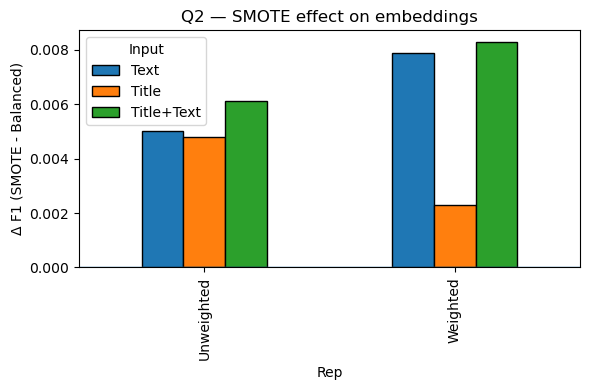

In [399]:
import matplotlib.pyplot as plt

ax = delta_f1.plot(kind="bar", figsize=(6,4), edgecolor="black")
ax.axhline(0, linewidth=1)
ax.set_ylabel("Δ F1 (SMOTE - Balanced)")
ax.set_title("Q2 — SMOTE effect on embeddings")
plt.tight_layout(); plt.show()

The plot shows the F1 improvement (ΔF1) when using **SMOTE vs class weighting** across embedding types and inputs:  

- **Unweighted embeddings:**  
  - SMOTE gives a small but consistent F1 boost for all inputs (~+0.005).  
  - The best gain is for **Title+Text** (~+0.006).  

- **Weighted embeddings:**  
  - SMOTE has a stronger effect, especially for **Text (+0.008)** and **Title+Text (+0.008)**.  
  - The gain for **Title** alone is minimal (~+0.002).  

**Takeaway:** SMOTE provides modest improvements in F1, with the biggest benefits seen in **Weighted embeddings with Text or Title+Text**.  
However, the improvements are still small overall, reinforcing that **class weighting already handles imbalance effectively**.

#### 3.3.3 Summary  

In **Question 2**, we explored whether adding the **Title** field improves classification performance.  

- **Impact of Title information:**  
  - Adding **Title+Text** consistently improved results across all representations.  
  - The best setup was **BoW + MultinomialNB**, reaching **F1 = 0.931, ROC-AUC = 0.931**, outperforming the Text-only baseline.  
  - **Title alone** was weaker than Text, but still better than nothing, and combining it with Text yielded the strongest gains.  

- **Model trends:**  
  - **BoW models** remained dominant, with Naive Bayes and Random Forest leading the board.  
  - **Embedding models** benefited most from **MLP**, which scored F1 ≈ 0.926 with Title or Title+Text, though still below BoW methods.  

- **Imbalance handling (Balanced vs SMOTE):**  
  - SMOTE gave small boosts in **Accuracy and F1** (up to +0.008) but slightly reduced **ROC-AUC and Balanced Accuracy**.  
  - Class weighting alone remained sufficient, with SMOTE offering only marginal improvements.  

**Overall:** Including Title enhances model performance, especially when combined with Text.  
While embeddings paired with neural models (MLP) show promise, the simplest approach — **BoW + Naive Bayes with Title+Text** — remains the most effective solution for this dataset.

## Conclusion  

In this notebook, we built feature representations and evaluated classification models for women’s clothing reviews.  

- **Task 2:** We generated three types of document representations — BoW, unweighted FastText embeddings, and TF-IDF weighted embeddings.  
  BoW offered strong baseline features, while embeddings provided dense semantic information but required more complex models to perform well.  

- **Task 3, Question 1:**  
  - **BoW** was the most effective representation overall, with **Multinomial Naive Bayes** achieving the top F1 (≈0.923) and ROC-AUC (≈0.900).  
  - Embeddings performed reasonably with non-linear models (MLP), but did not surpass BoW methods.  
  - Class weighting proved sufficient for handling imbalance; SMOTE offered only minor gains.  

- **Task 3, Question 2:**  
  - Adding **Title** improved performance across all representations.  
  - The best model was **BoW + Title+Text with Naive Bayes**, reaching **F1 ≈ 0.931**.  
  - Title alone was weaker than Text, but in combination, it provided clear value.  
  - Embedding models with MLP also benefited from Title, though they still trailed behind BoW approaches.  

**Final takeaway:**  
The simplest representation — **BoW combined with review Title and Text** — consistently outperformed more complex embedding-based methods.  
This highlights how, in practice, well-preprocessed BoW features with the right model can be highly effective for text classification tasks, even compared to modern embeddings.